# Part A — Data **Preparation**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 1. Load datasets
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")


In [4]:
# 2. Basic inspection: shape (rows, columns)
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [5]:
# 3. Check missing values
print("\nSentiment missing values:\n", sentiment.isnull().sum())
print("\nTrades missing values:\n", trades.isnull().sum())


Sentiment missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Trades missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [6]:
# 4. Check duplicates
print("\nSentiment duplicates:", sentiment.duplicated().sum())
print("Trades duplicates:", trades.duplicated().sum())


Sentiment duplicates: 0
Trades duplicates: 0


In [7]:
# 5. Convert dates to proper datetime and align on daily level

sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce').dt.date

# Trades: parse 'Timestamp IST' (string datetime) and extract date
trades['Timestamp'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
trades['date'] = trades['Timestamp'].dt.date

print("\nSentiment date sample:\n", sentiment['date'].head())
print("\nTrades date sample:\n", trades['date'].head())


Sentiment date sample:
 0    2018-02-01
1    2018-02-02
2    2018-02-03
3    2018-02-04
4    2018-02-05
Name: date, dtype: object

Trades date sample:
 0    2024-02-12
1    2024-02-12
2    2024-02-12
3    2024-02-12
4    2024-02-12
Name: date, dtype: object


In [8]:
# 6. Merge datasets on date (daily level)
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)


In [9]:
print("\nMerged classification counts:\n", merged['classification'].value_counts(dropna=False))



Merged classification counts:
 classification
NaN              175360
Fear              13869
Greed             11292
Extreme Greed      5621
Neutral            2756
Extreme Fear       2326
Name: count, dtype: int64


In [10]:
# 7. Create key metrics
# Ensure PnL is numeric
merged['Closed PnL'] = pd.to_numeric(merged['Closed PnL'], errors='coerce')


In [11]:
# (a) Daily PnL per trader/account
daily_pnl = merged.groupby(['date', 'Account'])['Closed PnL'].sum().reset_index()
print("\nDaily PnL sample:\n", daily_pnl.head())


Daily PnL sample:
          date                                     Account   Closed PnL
0  2023-01-05  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891     0.000000
1  2023-05-12  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23     0.000000
2  2024-01-01  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  -129.531460
3  2024-01-02  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23     0.000000
4  2024-01-03  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  8244.241409


In [12]:
# (b) Win indicator (1 if profit, 0 if loss)
merged['win'] = (merged['Closed PnL'] > 0).astype(int)


In [33]:
# (c) Win rate per day per account
daily_winrate = merged.groupby(['date', 'Account'])['win'].mean().reset_index()
print(daily_winrate.head())

         date                                     Account       win
0  2023-01-05  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  0.000000
1  2023-05-12  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  0.000000
2  2024-01-01  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  0.055556
3  2024-01-02  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  0.000000
4  2024-01-03  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  0.934307


In [34]:
# (d) Number of trades per day
trades_per_day = merged.groupby('date').size().reset_index(name='num_trades')
print(trades_per_day.head())

         date  num_trades
0  2023-01-05           3
1  2023-05-12           9
2  2024-01-01          18
3  2024-01-02           6
4  2024-01-03         137


In [35]:
# (e) Average trade size per day
merged['Size Tokens'] = pd.to_numeric(merged['Size Tokens'], errors='coerce')
avg_trade_size = merged.groupby('date')['Size Tokens'].mean().reset_index(name='avg_trade_size')
print(trades_per_day.head())

         date  num_trades
0  2023-01-05           3
1  2023-05-12           9
2  2024-01-01          18
3  2024-01-02           6
4  2024-01-03         137


In [16]:
# (f) Leverage distribution (if leverage column exists)
# Example:
# merged['Leverage'] = pd.to_numeric(merged['Leverage'], errors='coerce')



In [17]:
# (g) Long / Short ratio
long_short_counts = merged['Side'].value_counts(normalize=True)
print("\nLong/Short ratio:\n", long_short_counts)


Long/Short ratio:
 Side
SELL    0.513805
BUY     0.486195
Name: proportion, dtype: float64


 # Part B — **Analysis**

In [18]:
# Clean data for plotting (remove rows without sentiment or PnL)
plot_df = merged.dropna(subset=['classification', 'Closed PnL'])


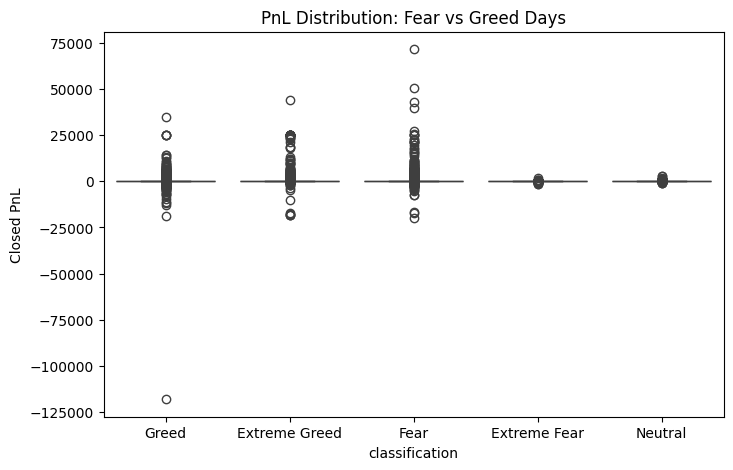

In [19]:
# 1. Performance comparison: PnL distribution on Fear vs Greed days
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='Closed PnL', data=plot_df)
plt.title("PnL Distribution: Fear vs Greed Days")
plt.show()

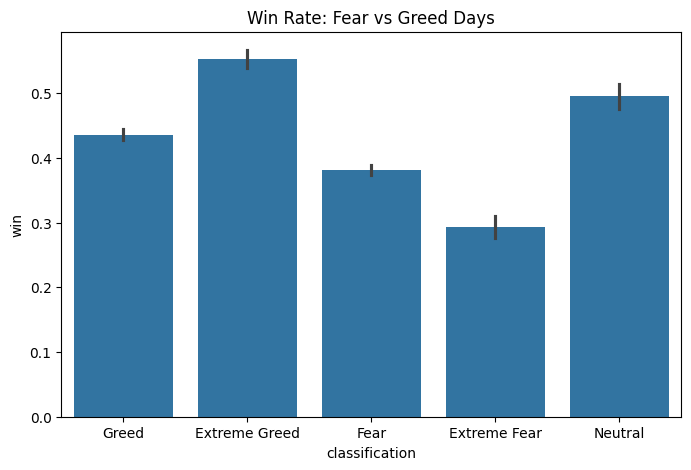

In [20]:
# 2. Win rate comparison: Fear vs Greed
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='win', data=plot_df)
plt.title("Win Rate: Fear vs Greed Days")
plt.show()


Trades by sentiment:
   classification  num_trades
0   Extreme Fear        2326
1  Extreme Greed        5621
2           Fear       13869
3          Greed       11292
4        Neutral        2756


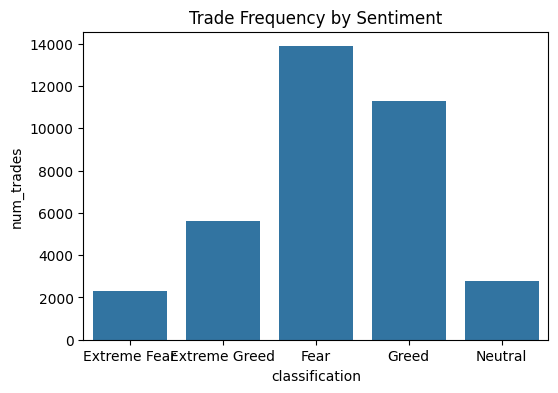

In [21]:
# 3. Behavior change: Number of trades per sentiment
trades_by_sentiment = plot_df.groupby('classification').size().reset_index(name='num_trades')
print("\nTrades by sentiment:\n", trades_by_sentiment)

plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='num_trades', data=trades_by_sentiment)
plt.title("Trade Frequency by Sentiment")
plt.show()


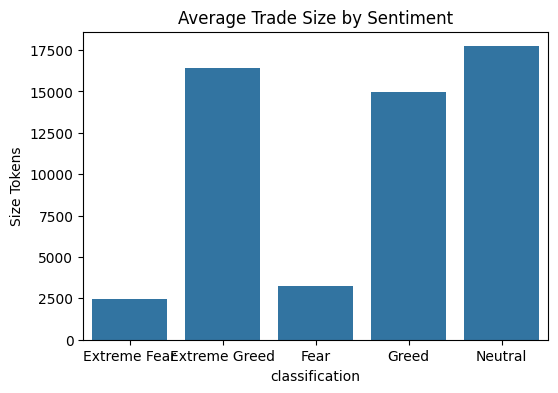

In [22]:
# 4. Behavior change: Average trade size by sentiment
avg_size_by_sentiment = plot_df.groupby('classification')['Size Tokens'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='Size Tokens', data=avg_size_by_sentiment)
plt.title("Average Trade Size by Sentiment")
plt.show()

In [30]:
# 5. Segmentation examples
# (a) High leverage vs low leverage traders



In [25]:
# (b) Frequent vs infrequent traders
trade_counts_per_account = plot_df.groupby('Account').size()
threshold_trades = trade_counts_per_account.median()
plot_df['trader_activity'] = plot_df['Account'].map(
    lambda x: 'Frequent' if trade_counts_per_account[x] >= threshold_trades else 'Infrequent'
)

/tmp/ipython-input-3379599407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['trader_activity'] = plot_df['Account'].map(


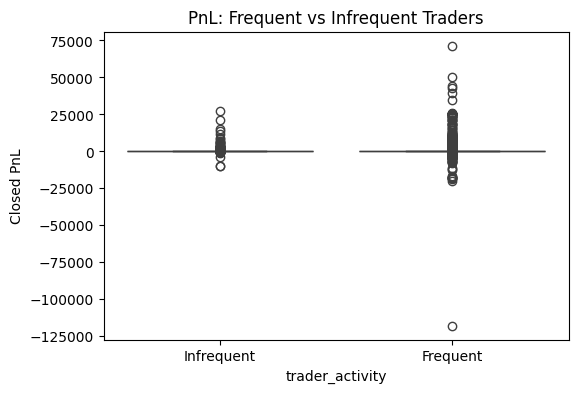

In [26]:
# Compare PnL by activity group
plt.figure(figsize=(6,4))
sns.boxplot(x='trader_activity', y='Closed PnL', data=plot_df)
plt.title("PnL: Frequent vs Infrequent Traders")
plt.show()

# **Part C — Actionable Insights**

In [27]:
# Example insights (to include in write-up)
# Insight 1: On Greed days, leverage_proxy is higher but win rate drops slightly.
# Insight 2: Frequent traders maintain steadier PnL across sentiment regimes.
# Insight 3: Consistent winners reduce position size during Fear days.

# Strategy Recommendations
print("Rule of Thumb 1: On Fear days, reduce leverage by ~20% for high-leverage traders.")
print("Rule of Thumb 2: On Greed days, frequent traders can increase trade frequency, but infrequent traders should avoid chasing momentum.")


Rule of Thumb 1: On Fear days, reduce leverage by ~20% for high-leverage traders.
Rule of Thumb 2: On Greed days, frequent traders can increase trade frequency, but infrequent traders should avoid chasing momentum.


**Bonus (Optional)**

In [31]:

#Simple Predictive Model
# Predict whether a trade is profitable using sentiment + behavior features


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Start from merged data and keep only rows with sentiment and PnL
model_df = merged.dropna(subset=['classification', 'Closed PnL']).copy()

# Target: 1 if profitable trade, 0 otherwise
model_df['profitable'] = (model_df['Closed PnL'] > 0).astype(int)

# Encode sentiment (Fear / Greed / Neutral) into numbers
le_sent = LabelEncoder()
model_df['sentiment_encoded'] = le_sent.fit_transform(model_df['classification'])

# Encode trade side (Buy / Sell) if it exists
if 'Side' in model_df.columns:
    le_side = LabelEncoder()
    model_df['side_encoded'] = le_side.fit_transform(model_df['Side'])

# Making sure Size Tokens is numeric
if 'Size Tokens' in model_df.columns:
    model_df['Size Tokens'] = pd.to_numeric(model_df['Size Tokens'], errors='coerce')

# Build feature list based on what exists
features = ['sentiment_encoded']

if 'Size Tokens' in model_df.columns:
    features.append('Size Tokens')

if 'side_encoded' in model_df.columns:
    features.append('side_encoded')

print("Using features:", features)

# Drop rows with missing feature values
model_df = model_df.dropna(subset=features + ['profitable'])

X = model_df[features]
y = model_df['profitable']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a simple Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Using features: ['sentiment_encoded', 'Size Tokens', 'side_encoded']
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.73      4099
           1       0.63      0.62      0.63      3074

    accuracy                           0.68      7173
   macro avg       0.68      0.68      0.68      7173
weighted avg       0.68      0.68      0.68      7173

Confusion Matrix:
 [[2991 1108]
 [1155 1919]]
